# Demo - Compare sensitivity curves

This demo shows how you can use `LEGWORK` to compare different detector sensitivitity curves. We illustrate these sensitivity curves as well as how the SNR of a source changes in different detectors.

In [1]:
%matplotlib inline

In [2]:
import legwork
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from copy import copy

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs}
plt.rcParams.update(params)

## Direct sensitivity curve comparisons
First, we can plot the sensitivity curves directly to see which regimes are better for different detectors. Let's look at different LISA specifications as well as the TianQin detector.

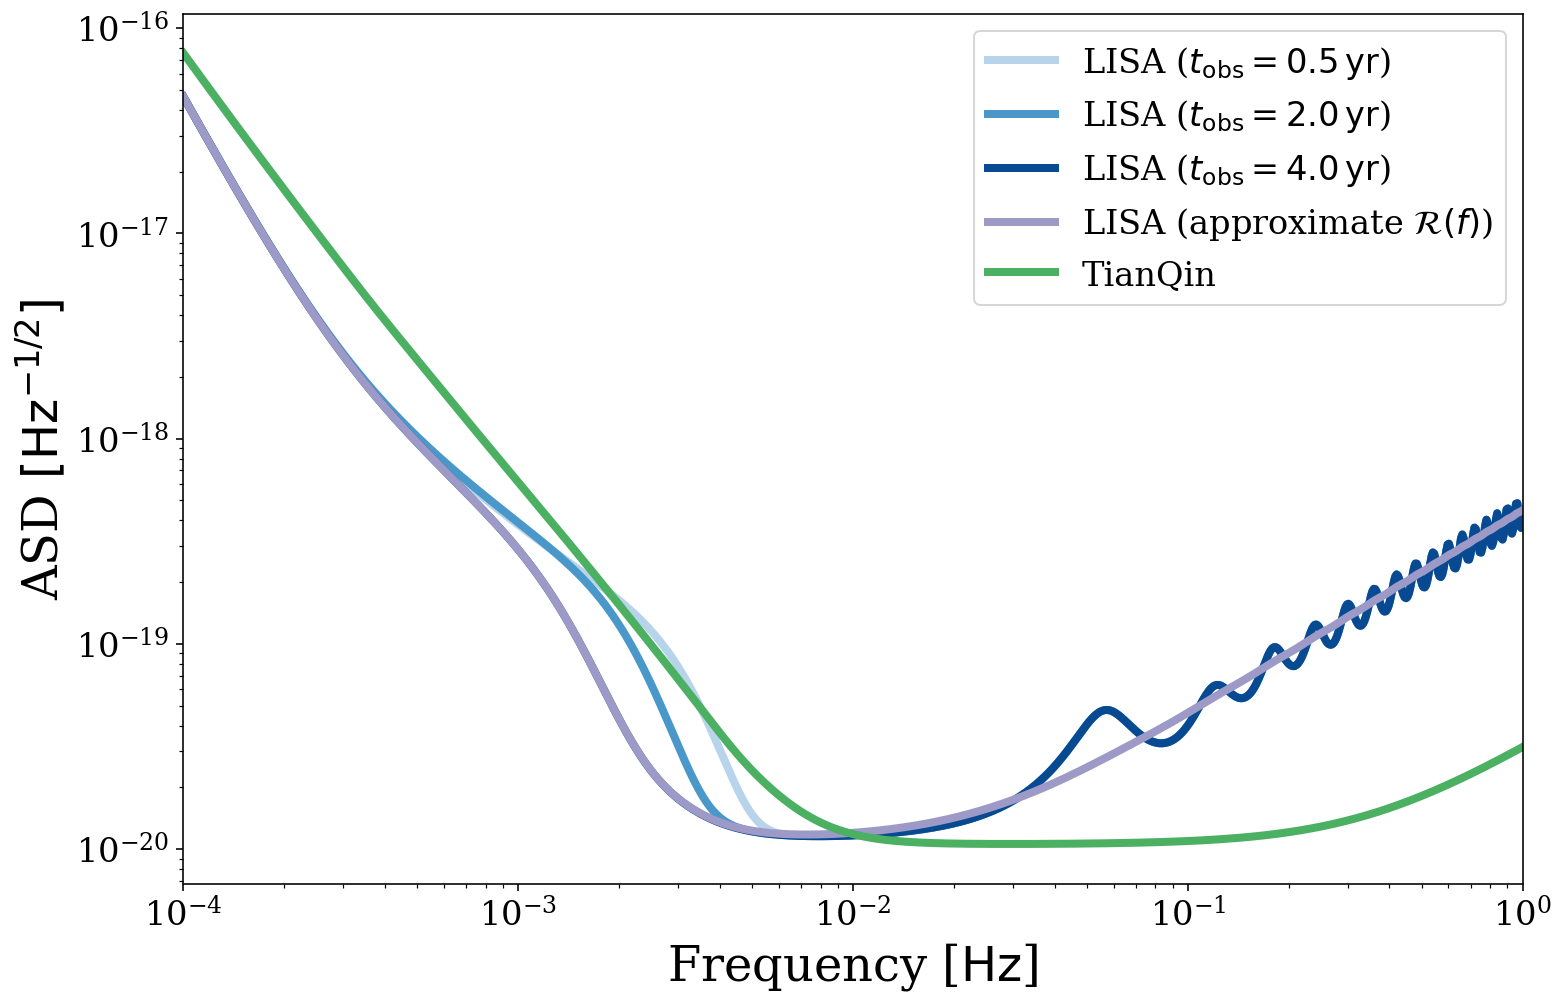

In [4]:
# create new figure
fig, ax = plt.subplots()

# define the frequency range of interest
fr = np.logspace(-4, 0, 1000) * u.Hz

# plot a sensitivity curve for different mission lengths
linewidth = 4
for i, t_obs in enumerate([0.5, 2.0, 4.0]):
    legwork.visualisation.plot_sensitivity_curve(frequency_range=fr, t_obs=t_obs * u.yr,
                                                 fig=fig, ax=ax, show=False, fill=False, linewidth=linewidth,
                                                 color=plt.get_cmap("Blues")((i + 1) * 0.3),
                                                 label=r"LISA ($t_{{\rm obs}} = {{{}}} \, {{\rm yr}}$)".format(t_obs))
    
# plot the LISA curve with an approximate response function
legwork.visualisation.plot_sensitivity_curve(frequency_range=fr, approximate_R=True,
                                             fig=fig, ax=ax, show=False, fill=False, linewidth=linewidth,
                                             color=plt.get_cmap("Purples")(0.5),
                                             label=r"LISA (approximate $\mathcal{R}(f)$)")
    
# plot the TianQin curve
legwork.visualisation.plot_sensitivity_curve(frequency_range=fr, instrument="TianQin", label="TianQin",
                                             fig=fig, ax=ax, show=False, linewidth=linewidth,
                                             color=plt.get_cmap("Greens")(0.6), fill=False)

ax.legend(fontsize=0.7*fs)

plt.show()

## SNR in different detectors
But we need not just look at the sensitivity curve, we could also investigate in what regimes of frequency and eccentricity each detector is superior. Let's compare a LISA to TianQin with a grid of sources across eccentricity and frequency space.

In [5]:
# spread out some frequencies and eccentricities
f_orb_s = np.logspace(-4, -1, 200) * u.Hz
ecc_s = np.linspace(0, 0.9, 150)

# turn them into a grid
F, E = np.meshgrid(f_orb_s, ecc_s)

# flatten the grid
F_flat, E_flat = F.flatten(), E.flatten()

# put all of the sources at the same distance with the same mass
m_1 = np.repeat(10, len(F_flat)) * u.Msun
m_2 = np.repeat(10, len(F_flat)) * u.Msun
dist = np.repeat(8, len(F_flat)) * u.kpc

# define a set of sources
sources = legwork.source.Source(m_1=m_1, m_2=m_2, f_orb=F_flat, ecc=E_flat, dist=dist, gw_lum_tol=1e-3)
sources.get_merger_time()

<Quantity [4.06824606e-03, 3.70856767e-03, 3.38068886e-03, ...,
           1.66795562e-13, 1.52048971e-13, 1.38606144e-13] Gyr>

In [6]:
# compute the LISA SNR
LISA_snr = copy(sources.get_snr(verbose=True, which_sources=sources.t_merge > 0.1 * u.yr))

Calculating SNR for 26248 sources
	0 sources have already merged
	13486 sources are stationary
		222 sources are stationary and circular
		13264 sources are stationary and eccentric
	12762 sources are evolving
		158 sources are evolving and circular
		12604 sources are evolving and eccentric


In [7]:
# compute the TianQin SNR
sources.update_sc_params({"instrument": "TianQin"})
TQ_snr = sources.get_snr(verbose=True, which_sources=sources.t_merge > 0.1 * u.yr)

Calculating SNR for 26248 sources
	0 sources have already merged
	13126 sources are stationary
		216 sources are stationary and circular
		12910 sources are stationary and eccentric
	13122 sources are evolving
		164 sources are evolving and circular
		12958 sources are evolving and eccentric


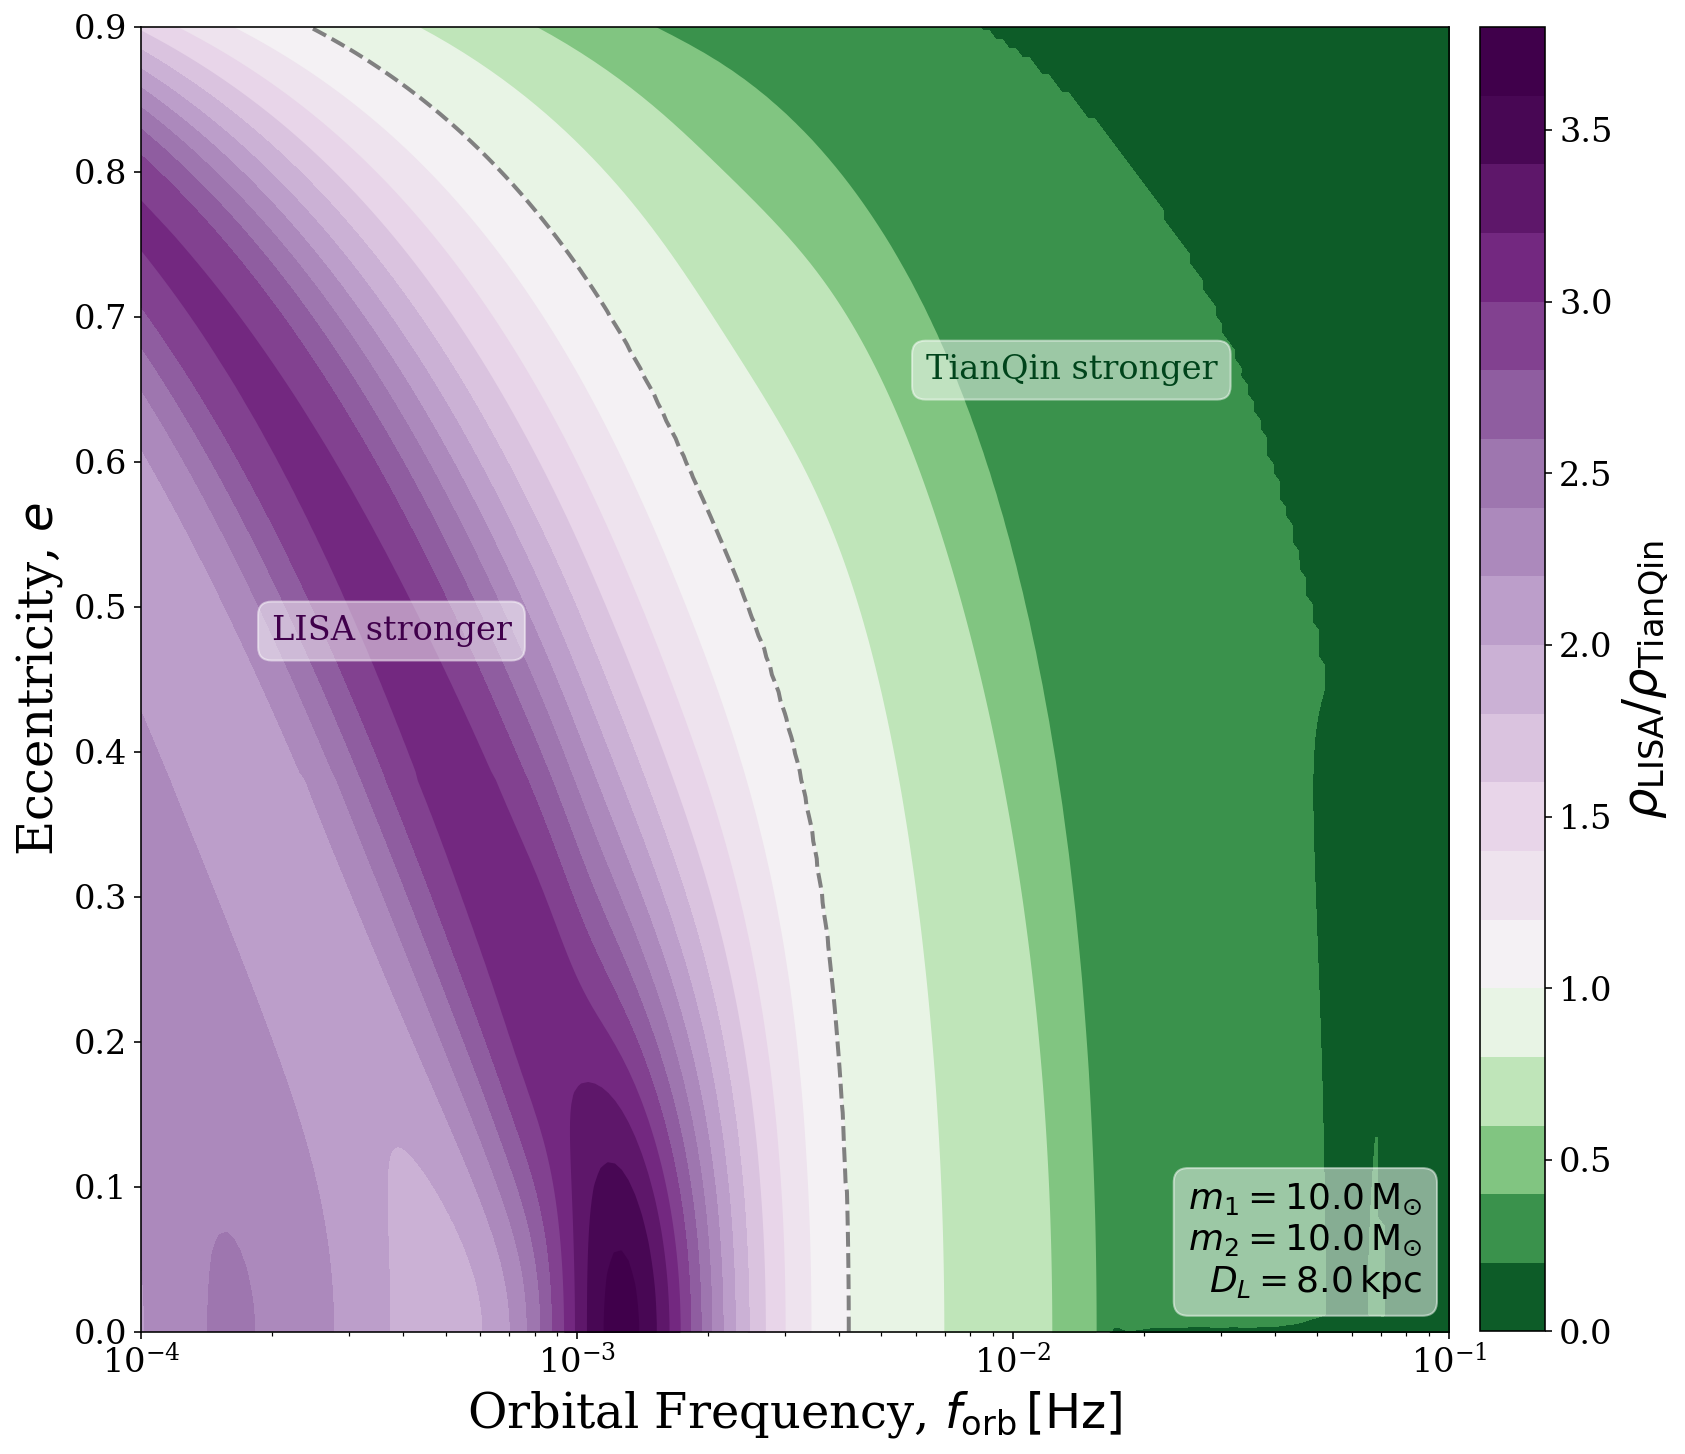

In [10]:
# create a figure
fig, ax = plt.subplots(figsize=(14, 12))
ax.set_xscale("log")
ax.set_xlabel(r"Orbital Frequency, $f_{\rm orb} \, [{\rm Hz}]$")
ax.set_ylabel(r"Eccentricity, $e$")

ratio = np.zeros_like(LISA_snr)
ratio[LISA_snr > 0] = (LISA_snr[LISA_snr > 0] / TQ_snr[LISA_snr > 0])
ratio = ratio.reshape(F.shape)

# make contours of the ratio of SNR
ratio_cont = ax.contourf(F, E, ratio, cmap="PRGn_r",
                         norm=TwoSlopeNorm(vcenter=1.0, vmin=0.0, vmax=3.6), levels=20)

for c in ratio_cont.collections:
    c.set_edgecolor("face")

# add a line when the SNRs are equal
ax.contour(F, E, ratio, levels=[1.0], colors="grey", linewidths=2.0, linestyles="--")

# add a colourbar
cbar = fig.colorbar(ratio_cont, fraction=2/14, pad=0.02,
                    label=r"$\rho_{\rm LISA} / \rho_{\rm TianQin}$",
                    ticks=np.arange(0, 3.5 + 0.5, 0.5))

# annotate which regions suit each detector
ax.annotate("LISA stronger", xy=(0.1, 0.53), xycoords="axes fraction", fontsize=0.7 * fs,
            color=plt.get_cmap("PRGn_r")(1.0),
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="white", alpha=0.5, pad=0.4))
ax.annotate("TianQin stronger", xy=(0.6, 0.73), xycoords="axes fraction", fontsize=0.7 * fs,
            color=plt.get_cmap("PRGn_r")(0.0),
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="white", alpha=0.5, pad=0.4))

# annotate with source details
source_string = r"$m_1 = {{{}}} \, {{ \rm M_{{\odot}}}}$".format(m_1[0].value)
source_string += "\n"
source_string += r"$m_2 = {{{}}} \, {{ \rm M_{{\odot}}}}$".format(m_1[0].value)
source_string += "\n"
source_string += r"$D_L = {{{}}} \, {{ \rm kpc}}$".format(dist[0].value)
ax.annotate(source_string, xy=(0.98, 0.03), xycoords="axes fraction", ha="right", fontsize=0.75*fs,
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="white", alpha=0.5, pad=0.4))

plt.show()

From this plot we can see that for circular sources at low frequenies LISA produces a stronger SNR. As eccentricity is increases, the range of frequencies at which LISA is superior decreases until at $e = 0.9$, TianQin is better at every frequency greater than approximately 0.3mHz!